In [1]:
import pandas as pd
%pylab inline
import seaborn as sns
from datetime import datetime
from sqlalchemy import create_engine
import plotly.express as px
import calendar
plt.style.use('dark_background')

Populating the interactive namespace from numpy and matplotlib


In [2]:
df=pd.read_csv('data.csv',encoding = "ISO-8859-1" )
print( df.shape)
df.head(3)


(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


- InvoiceDate needs converions 
- We have negative Quantity & Unit price they need to be removed
- Mising values in Description & CustomerID, they need to be dealt with

In [6]:
print('{0} rows and {1} columns'.format(df.shape[0], df.shape[1]))
print('*'*10,' Missing values Reports ','*'*10, '\n')
print(df.isnull().sum())
print('*'*10,' Descriptive Statisticsc ','*'*10, '\n')
print (df.describe())

541909 rows and 8 columns
**********  Missing values Reports  ********** 

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
**********  Descriptive Statisticsc  ********** 

            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000


# DATA PREPROCESSING

In [7]:

df['Hour']=df['InvoiceDate'].str.split(' ').str[1] # get the hours

df['InvoiceDate']=df['InvoiceDate'].str.split(' ').str[0]# keeping the dates without the hours

df['Year']=df['InvoiceDate'].str.split('/').str[2] # get the years
df['Month']=df['InvoiceDate'].str.split('/').str[0] # get the months

df['Month']=df['Month'].astype(int) # changing months into int

df=df[(df['Quantity']>0)|(df['UnitPrice']>0)]# keeping the positive values in Quantity and Unit Price

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']) # changing the datatype to date 

df.dropna(inplace=True) # removing all missing values - no need for those rows :)

# QUICK OVERALL VISUALISATION 

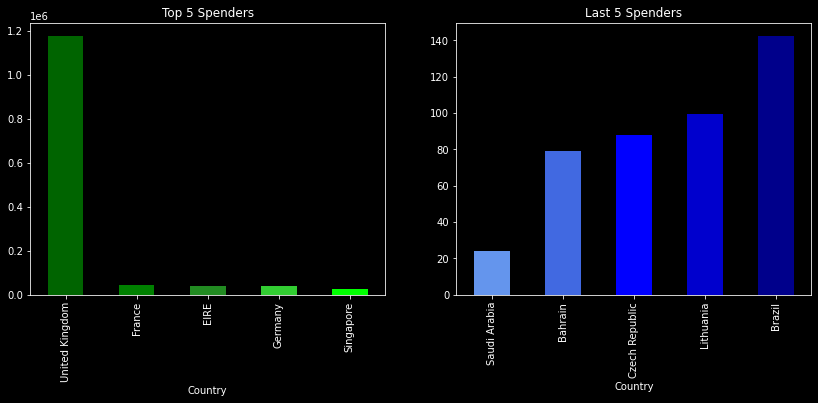

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,5)) 
df.groupby('Country')['UnitPrice'].sum().sort_values(ascending=False)[:5].plot(
    kind='bar', ax=ax1, title= 'Top 5 Spenders', 
    color=['darkgreen','green','forestgreen','limegreen','lime'])

df.groupby('Country')['UnitPrice'].sum().sort_values(ascending=True)[:5].plot(
    kind='bar', ax=ax2, title='Last 5 Spenders',
    color=['cornflowerblue','royalblue','blue','mediumblue','darkblue']);

In [10]:
df1=df[df['Year']=='2011']

df2=df1.groupby('Month')['UnitPrice'].sum().reset_index()
df2['Month']=df2['Month'].astype(int)
df2.sort_values(by=['Month'], ascending=True, inplace=True)
df2['month'] = df2['Month'].apply(lambda x: calendar.month_abbr[x])

In [11]:
data=[]
data.insert(0,{'Month':'1', 'UnitPrice':df[df['Year']=='2010']['UnitPrice'].sum(),'month':'Dec 2010'})

In [12]:
df2=pd.concat([pd.DataFrame(data), df2], ignore_index=True)

Text(5, 180000, '2011')

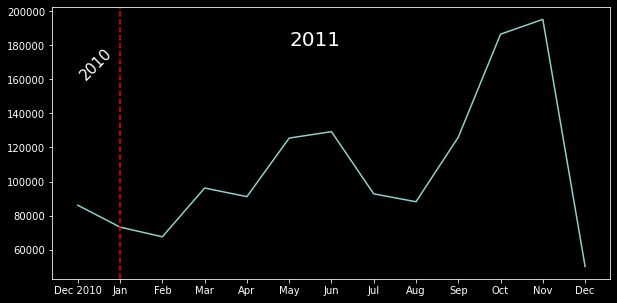

In [13]:
plt.figure(figsize=(10,5))
plt.plot(df2['month'],df2['UnitPrice'])
plt.axvline(x=1, linestyle='--', color='r')
plt.text(x=0, y=160000, s='2010', fontsize=15, rotation=45)
plt.text(x=5, y=180000, s='2011', fontsize=20)

# SQlite

In [14]:
engine = create_engine('sqlite://', echo=False)
df.to_sql('store', con=engine)

In [15]:
# Product that sells the most 
engine.execute('''Select Description, count(*) 
from store 
group by Description 
order by count(*) desc
limit 10''').fetchall()

[('WHITE HANGING HEART T-LIGHT HOLDER', 2070),
 ('REGENCY CAKESTAND 3 TIER', 1905),
 ('JUMBO BAG RED RETROSPOT', 1662),
 ('ASSORTED COLOUR BIRD ORNAMENT', 1418),
 ('PARTY BUNTING', 1416),
 ('LUNCH BAG RED RETROSPOT', 1358),
 ('SET OF 3 CAKE TINS PANTRY DESIGN ', 1232),
 ('POSTAGE', 1196),
 ('LUNCH BAG  BLACK SKULL.', 1126),
 ('PACK OF 72 RETROSPOT CAKE CASES', 1080)]

In [16]:
# Customer that has come the most
engine.execute('''
Select CustomerID, count(distinct(InvoiceNo)) as total_spend
from store group by CustomerID
order by total_spend desc
limit 5''').fetchall()


[(14911.0, 248),
 (12748.0, 224),
 (17841.0, 169),
 (14606.0, 128),
 (15311.0, 118)]

In [17]:
engine.execute('''Select CustomerID, total_spend from
(Select CustomerID, count(distinct(InvoiceNo))as Total_Invoice, round(sum(UnitPrice),2) as total_spend
from store group by CustomerID
order by total_spend desc)
limit 5''').fetchall()

[(14096.0, 41376.33),
 (15098.0, 40278.9),
 (14911.0, 31060.66),
 (12744.0, 25108.89),
 (16029.0, 24111.14)]

In [18]:
# top Customers - Those that have come the most orders
engine.execute('''Select CustomerID, count(distinct(InvoiceNo))as Total_Invoice, round(sum(UnitPrice),2)
from store group by CustomerID
order by Total_Invoice desc
limit 5''').fetchall()

[(14911.0, 248, 31060.66),
 (12748.0, 224, 15115.6),
 (17841.0, 169, 20333.18),
 (14606.0, 128, 7839.02),
 (15311.0, 118, 6267.75)]

# COHORT ANALYSIS

In a Commercial world, A cohort refers to a subset of customers that share the same characteristics ( in our case customers that have joined around the same date).<br> While a **Cohort Analysis** allows is merely a representation of differents subsets or cohorts over time. It allows you to ask more specific, targeted questions and make informed product decisions that will reduce churn and drastically increase revenue. You could also call it customer churn analysis.<br>
**A Churn is a turn offenly used in Survival Analyis to signal when a member of a population dies**. e.g. 
- How long does it take for a person dies under a certain treament; but also
- How long does it take for a customer to cancel his/her subcription or stop buying products


In [19]:
cohort_df=df.copy() 
cohort_df.drop(['StockCode', 'Description', 'Country'], axis=1, inplace=True)

In [20]:
#let's create an invoice month
cohort_df['Invoice_Month']=cohort_df['InvoiceDate'].dt.strftime('%Y-%m')

# change the datatype back to date 
cohort_df['Invoice_Month']=pd.to_datetime(cohort_df['Invoice_Month'])

In [21]:
# getting the minimum date for each customer
cohort_df['Cohort_Month']=cohort_df.groupby('CustomerID')['Invoice_Month'].transform('min')
#cohort_df['Cohort_Month']=pd.to_datetime(cohort_df['Cohort_Month'])

In [22]:
cohort_df.head(3)

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Hour,Year,Month,Invoice_Month,Cohort_Month
0,536365,6,2010-12-01,2.55,17850.0,8:26,2010,12,2010-12-01,2010-12-01
1,536365,6,2010-12-01,3.39,17850.0,8:26,2010,12,2010-12-01,2010-12-01
2,536365,8,2010-12-01,2.75,17850.0,8:26,2010,12,2010-12-01,2010-12-01


### Long road (Pivot Way)/ Use this way  as an alternative

def get_date(df, col):
    year = df[col].dt.year
    month = df[col].dt.month
    day = df[col].dt.day
    return year, month , day 

invoice_year,invoice_month,_ = get_date(cohort_df,'Invoice_Month')
cohort_year,cohort_month,_ = get_date(cohort_df,'Cohort_Month')

year_diff = invoice_year - cohort_year 
month_diff = invoice_month - cohort_month

df['Period'] = year_diff * 12 + month_diff + 1

### Calculate the number of active customer in each cochot 
active_cust=cohort_df.groupby(['Cohort_Month','Period'])

### Count the number of each group
cohort_data = active_cust['CustomerID'].apply(pd.Series.nunique)
cohort_data=cohort_data.reset_index()

cohort_table=cohort_data.pivot(index='Cohort_Month', values='CustomerID', columns= 'Period')
cohort_table

In [23]:
def month_diff(date1:datetime, date2:datetime) ->int:
    return((date1.dt.year - date2.dt.year) * 12 + date1.dt.month - date2.dt.month)

In [24]:
cohort_df['Period'] = month_diff(cohort_df['Invoice_Month'], cohort_df['Cohort_Month'])

In [25]:
# pivot table to create the Cohort analysis 
cohort=cohort_df.pivot_table(index='Cohort_Month', columns='Period',values='CustomerID', aggfunc='nunique')

In [26]:
plt.style.use('default')

In [27]:
cohort

Period,0,1,2,3,4,5,6,7,8,9,10,11,12
Cohort_Month,,,,,,,,,,,,,
2010-12-01,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02-01,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03-01,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04-01,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05-01,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Explanation of the DataFrame Above
Above is a Aquisition Cohort Analyis visualisation. 

- The first column which is the Cohort_Month is refers to the month. teh column also contains the years because
we have one full year of 2011 and one month from the year before.

- The Column 0 represents the total number of customers we have from at the start or month 0.
- The Column 1 represnts the number that customer than came back the second month, 2 the third, 3 the fourth etc..<br>
e.g. For the first cohort group of 2010-12-01 - we have 948 customers to start with, but only 362 for the first month and 317 for the second month etc...

In [28]:
size=cohort.iloc[:,0]
retention = cohort.divide(size, axis=0)
retention.round(2) * 100

Period,0,1,2,3,4,5,6,7,8,9,10,11,12
Cohort_Month,,,,,,,,,,,,,
2010-12-01,100.0,38.0,33.0,39.0,36.0,40.0,38.0,35.0,35.0,39.0,37.0,50.0,27.0
2011-01-01,100.0,24.0,28.0,24.0,33.0,30.0,26.0,26.0,31.0,35.0,37.0,15.0,NaN
2011-02-01,100.0,25.0,19.0,28.0,27.0,25.0,26.0,28.0,26.0,31.0,9.0,NaN,NaN
2011-03-01,100.0,19.0,25.0,22.0,23.0,18.0,26.0,24.0,29.0,9.0,NaN,NaN,NaN
2011-04-01,100.0,23.0,22.0,21.0,21.0,24.0,23.0,26.0,8.0,NaN,NaN,NaN,NaN
2011-05-01,100.0,24.0,17.0,17.0,22.0,24.0,27.0,10.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,21.0,19.0,27.0,25.0,34.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,21.0,20.0,23.0,27.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,25.0,25.0,25.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


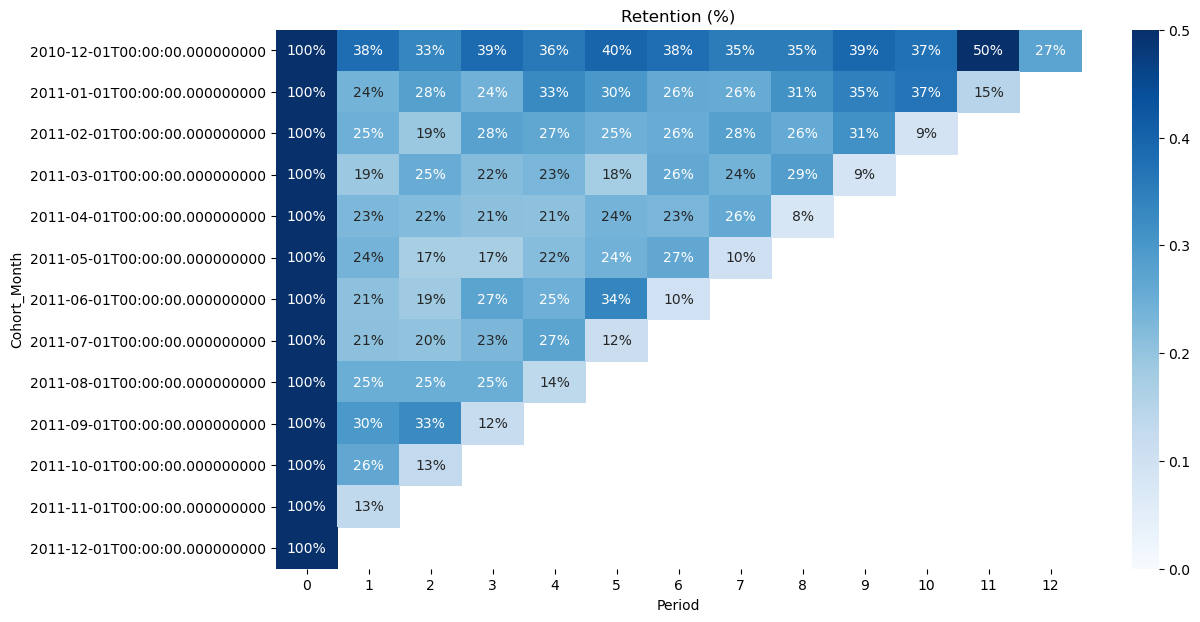

In [29]:
plt.figure(figsize=(13, 7))
plt.title('Retention (%)')
sns.heatmap(retention, annot = True, fmt = '.0%', vmin = 0.0, vmax = 0.5, cmap = 'Blues')
plt.show()